In [1]:
import os, sys

import xml.etree.ElementTree as eT

import pyqtgraph as pg
from PyQt5 import QtWidgets, QtCore, QtGui

import numpy as np
from pandas import read_csv

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import scipy.ndimage as scind
from skimage.feature import peak_local_max
import skimage.measure
import skimage.morphology
import skimage.segmentation
import skimage.filters

from copy import deepcopy
from itertools import product, combinations

path = '/Users/hanmanhyuk/Documents/Remote Server/2023-11-10-WT+doublet+cDC1/'

In [2]:
fov_tile_info = read_csv(path + '2023-11-10-AlignedMosaictileULs.csv')
line = fov_tile_info.iloc[0]
x,y,w,h = line['x'], line['y'], line['w'], line['h']
fid_image = plt.imread('/Users/hanmanhyuk/Documents/Remote Server/2023-11-10-WT+doublet+cDC1/2023-11-10-Alignedmosaic_c001.tif')
img = fid_image[y-1:y+h-1,x-1:x+w-1]

/var/folders/fk/cnc_t_hd70jd0856y0sr24cw0000gq/T/ipykernel_19749/3801718788.py:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(dist_transform, indices=False, min_distance=7)


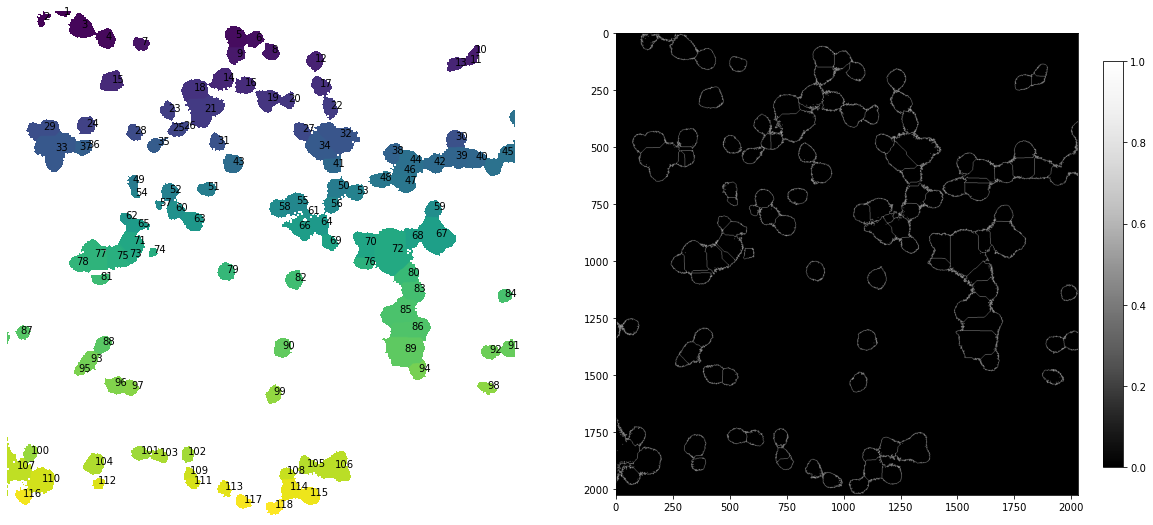

In [3]:
b = skimage.filters.threshold_otsu(img)
opening = skimage.morphology.opening((img > b).astype(int))
four_connect = scind.generate_binary_structure(2,1)
dist_transform = scind.morphology.distance_transform_edt(opening)
localMax = peak_local_max(dist_transform, indices=False, min_distance=7)
markers = scind.label(localMax, structure=np.ones((3,3)))[0]
wat = skimage.segmentation.watershed(-dist_transform, markers, mask=opening,)#watershed_line=True)
watori = wat.copy()
for i in np.unique(wat)[1:]:
    if (wat == i).sum() < 1000:
        wat[(wat == i)] = 0
for i,u in enumerate(np.unique(wat)):
    wat[(wat == u)] = i
watvis = wat.copy().astype(float)
watvis[watvis == 0] = np.nan
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(watvis, cmap=cm.viridis)
plt.axis(False)

for i in np.unique(wat)[1:]:
    y,x = np.where(wat == i)
    plt.text(x.mean(),y.mean(), f'{i}')
plt.subplot(122)
line = wat - skimage.morphology.erosion(wat)
plt.imshow((line != 0), cmap=cm.Greys_r)

plt.colorbar(fraction=0.04)

array([  406.05,   809.6 ,  1213.15,  1616.7 ,  2020.25,  2423.8 ,
        2827.35,  3230.9 ,  3634.45,  4038.  ,  4441.55,  4845.1 ,
        5248.65,  5652.2 ,  6055.75,  6459.3 ,  6862.85,  7266.4 ,
        7669.95,  8073.5 ,  8477.05,  8880.6 ,  9284.15,  9687.7 ,
       10091.25, 10494.8 , 10898.35, 11301.9 , 11705.45, 12109.  ])

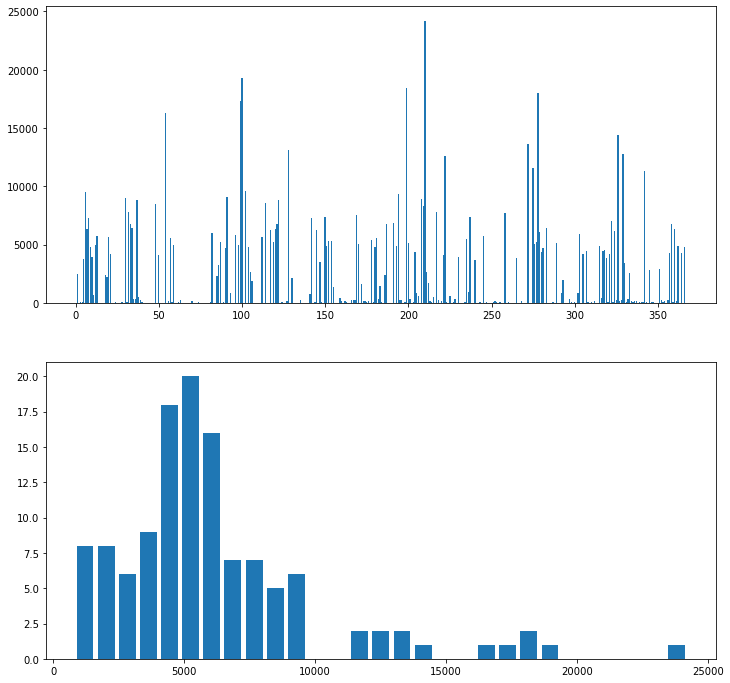

In [4]:
cell_size = [(watori == i).sum() for i in np.unique(watori)[1:]]
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.bar(np.arange(len(cell_size))+1, cell_size)
p,q = np.histogram(cell_size, bins=30)
plt.subplot(212)
plt.bar(1/2*(q[2:]+q[1:-1]),p[1:],(q[2:]-q[1:-1]).mean()*.8)
1/2*q[1:]

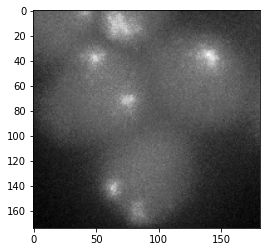

In [5]:
cell_size = [(wat == i).sum() for i in np.unique(wat)]
id = np.argsort(cell_size)[::-1][2]
a = np.arange(wat.shape[0])[(wat == id).sum(0) > 0]
b = np.arange(wat.shape[1])[(wat == id).sum(1) > 0]
ymin, ymax= b[0], b[-1]
xmin, xmax = a[0], a[-1]
crop_img = img[ymin:ymax+1,xmin:xmax+1]
plt.imshow(crop_img, cmap=cm.Greys_r)

667
1048
675
675
1048
143
111


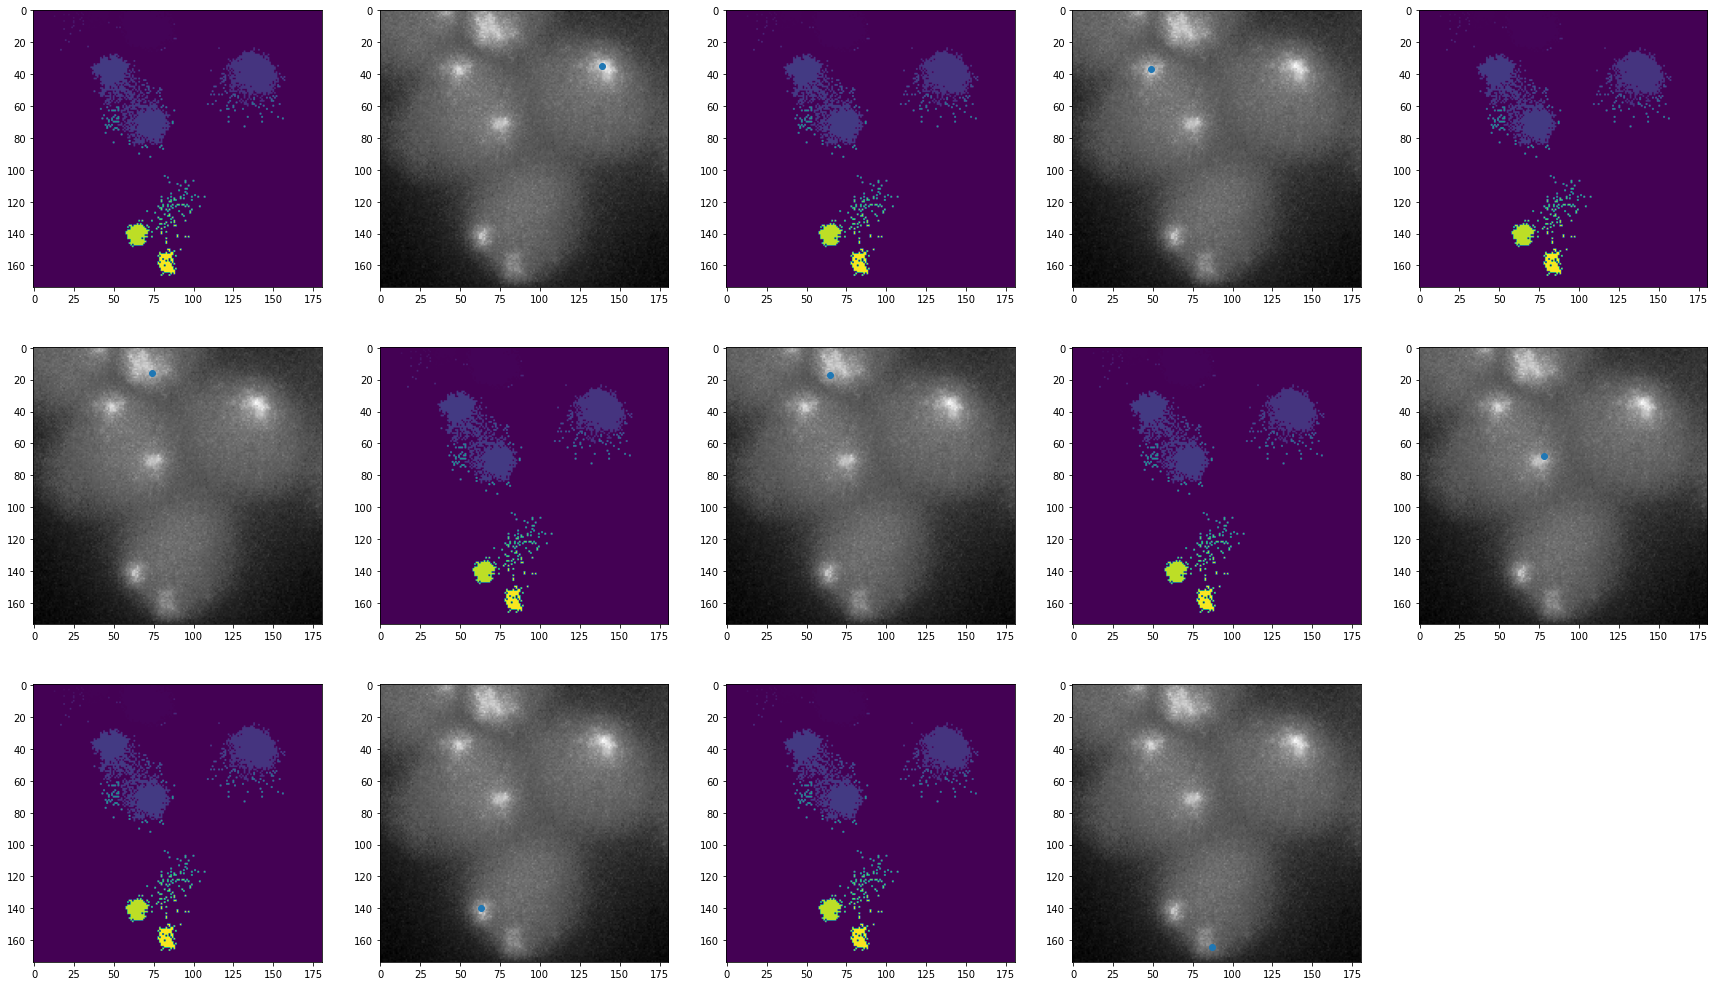

In [6]:
import skimage.measure
plt.figure(figsize=(30,30))
#for thres in np.linspace(0,1,10):
#    if len(pks) <= 7: break
pks = peak_local_max(crop_img, min_distance=7, threshold_rel=.1, num_peaks=7, num_peaks_per_label=1)
    
a = len(pks) // 2 + 2
for i in range(len(pks)):
    y,x = pks[i]
    im = np.zeros_like(crop_img)
    im[crop_img >= crop_img[pks[:,0], pks[:,1]].mean() * .7] = 1#crop_img[y,x] * .7] = 1
    #print(crop_img[y,x])
    plt.subplot(a,a,1+2*i)
    label = skimage.measure.label(im)
    plt.imshow(label)
    print((label == label[y,x]).sum())
    plt.subplot(a,a,2+2*i)
    plt.imshow(crop_img, cmap=cm.Greys_r)
    plt.scatter(x,y)


In [117]:
label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [93]:
y,x = np.where(crop_img > 6000)
crop_img[y,x],y,x

(array([7171, 6916, 6789, ..., 6470, 6056, 6024], dtype=uint16),
 array([  0,   0,   0, ..., 172, 172, 172]),
 array([ 0,  1,  2, ..., 84, 85, 87]))

In [95]:
crop_img[0,1]

6916

In [85]:
skimage.filters.threshold_li(img), skimage.filters.threshold_triangle(img), skimage.filters.threshold_yen(img), skimage.filters.threshold_otsu(img)

(5186.7156377812635, 4176, 9116, 5610)

In [7]:
fid_image.shape

(37530, 37530)